## Space Invaders With DQN

## Step 0: For run in Google Colab

1- For using Space Invaders in Colab we need to download ROMS and Import the environment

In [ ]:
# 1- Run this cell to Import the environment
! wget http://www.atarimania.com/roms/Roms.rar
! mkdir /content/ROM/
! unrar e /content/Roms.rar /content/ROM/
! python -m atari_py.import_roms /content/ROM/

2- To displaye the Agent & Environment we use env.render() but not work in colab, for runing env.render() use the below cells

In [ ]:
# 2- Dowload and install requirements
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
!apt-get update > /dev/null 2>&1
!apt-get install cmake > /dev/null 2>&1
!pip install --upgrade setuptools 2>&1
!pip install ez_setup > /dev/null 2>&1
!pip install gym[atari] > /dev/null 2>&1

In [ ]:
# Next, we define the functions used to show the video by adding it to the CoLab 
import gym
from gym.wrappers import Monitor
import glob
import io
import base64
from IPython.display import HTML
from pyvirtualdisplay import Display
from IPython import display as ipythondisplay

display = Display(visible=0, size=(1400, 900))
display.start()

"""
Utility functions to enable video recording of gym environment 
and displaying it.
To enable video, just do "env = wrap_env(env)""
"""


def show_video():
    mp4list = glob.glob('video/*.mp4')
    if len(mp4list) > 0:
        mp4 = mp4list[0]
        video = io.open(mp4, 'r+b').read()
        encoded = base64.b64encode(video)
        ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
    else:
        print("Could not find video")


def wrap_env(env):
    env = Monitor(env, './video', force=True)
    return env


## Step 1: Import the libraries

In [ ]:
import time
import gym
from gym import logger as gymlogger
from gym.wrappers import Monitor
gymlogger.set_level(30)
import random
import torch
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
import math

In [ ]:
# Local Libraries
from dqn_agent import DQNAgent
from dqn_cnn import DQNCnn
from stack_frame import preprocess_frame, stack_frame

## Step 2: Create our environment

Initialize the environment in the code cell below.

**Note**: If you to run this notebook in your PC

    1. pip uninstall gym 
    2. pip install gym 
    3. env = gym.make('SpaceInvaders-v0', render_mode='human')
    render_mode='human' is for show the graphical environment output

In [ ]:
env = wrap_env(gym.make('SpaceInvaders-v0')) # for google colab # Comment this when use PC
#env = gym.make('SpaceInvaders-v0', render_mode='human') # for run in PC
env.seed(0)

[0, 592379725]

In [ ]:
# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device: ", device)

Device:  cuda


## Step 3: Viewing our Enviroment

The size of frame is:  (210, 160, 3)
No. of Actions:  6




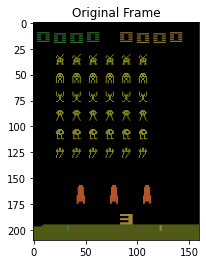

In [ ]:
print("The size of frame is: ", env.observation_space.shape)
print("No. of Actions: ", env.action_space.n)
print("\n")
env.reset()
plt.figure()
plt.imshow(env.reset())
plt.title('Original Frame')
plt.show()

### Execute the code cell below to play with a random policy.

In [ ]:
env = wrap_env(gym.make('SpaceInvaders-v0')) # Comment this when use PC
def random_play():
    score = 0
    env.reset()
    while True: 
        env.render() # it is OK for GOOGLE COLAB # Comment this when use PC
        # env.render('rgb_array') for using in PC
        action = env.action_space.sample()
        state, reward, done, _ = env.step(action)
        score += reward
        if done:
            env.close()
            show_video() # Comment this when use PC
            print("Your Score at end of game is: ", score)
            break
random_play()

Your Score at end of game is:  50.0


# Step 4: Preprocessing Frame

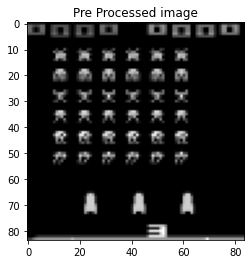

In [ ]:
env.reset()
plt.figure()
plt.imshow(preprocess_frame(env.reset(), (8, -12, -12, 4), 84), cmap="gray")
plt.title('Pre Processed image')
plt.show()

## Step 5: Stacking Frame

In [ ]:
def stack_frames(frames, state, is_new=False):
    frame = preprocess_frame(state, (8, -12, -12, 4), 84)
    frames = stack_frame(frames, frame, is_new)

    return frames

## Step 6: Creating our Agent

In [ ]:
INPUT_SHAPE = (4, 84, 84)
ACTION_SIZE = env.action_space.n
SEED = 0
GAMMA = 0.99           # discount factor
BUFFER_SIZE = 100000   # replay buffer size
BATCH_SIZE = 64        # Update batch size
LR = 0.0001            # learning rate 
TAU = 1e-3             # for soft update of target parameters
UPDATE_EVERY = 1       # how often to update the network
UPDATE_TARGET = 10000  # After which thershold replay to be started 
EPS_START = 0.99       # starting value of epsilon
EPS_END = 0.01         # Ending value of epsilon
EPS_DECAY = 100        # Rate by which epsilon to be decayed

agent = DQNAgent(INPUT_SHAPE, ACTION_SIZE, SEED, device, BUFFER_SIZE, BATCH_SIZE, GAMMA, LR, TAU, UPDATE_EVERY, UPDATE_TARGET, DQNCnn)

## Step 7: Watching untrained agent play

In [ ]:
# watch an untrained agent
state = stack_frames(None, env.reset(), True)  # Comment this when use PC
for j in range(200):
    env.render() # for google colab it is ok # Comment this when use PC
    # env.render('rgb_array') foo pc
    action = agent.act(state)
    next_state, reward, done, _ = env.step(action)
    state = stack_frames(state, next_state, False)
    if done:
        break 
        
env.close()
show_video() # Comment this when use PC

## Step 8: Loading Agent
Uncomment line to load a pretrained agent

In [ ]:
start_epoch = 0
scores = []
scores_window = deque(maxlen=20)

## Step 9: Train the Agent with DQN

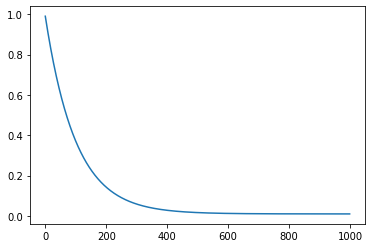

In [ ]:
epsilon_by_epsiode = lambda frame_idx: EPS_END + (EPS_START - EPS_END) * math.exp(-1. * frame_idx /EPS_DECAY)

plt.plot([epsilon_by_epsiode(i) for i in range(1000)])

In [ ]:
def train(n_episodes=1000):
    """
    Params
    ======
        n_episodes (int): maximum number of training episodes
    """
    for i_episode in range(start_epoch + 1, n_episodes+1):
        state = stack_frames(None, env.reset(), True)
        score = 0
        eps = epsilon_by_epsiode(i_episode)
        while True:
            action = agent.act(state, eps)
            next_state, reward, done, info = env.step(action)
            score += reward
            next_state = stack_frames(state, next_state, False)
            agent.step(state, action, reward, next_state, done)
            state = next_state
            if done:
                break
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
            fig = plt.figure()
            ax = fig.add_subplot(111)
            plt.plot(np.arange(len(scores)), scores)
            plt.ylabel('Score')
            plt.xlabel('Episode')
            plt.show()
    
    return scores

Episode 100	Average Score: 169.00


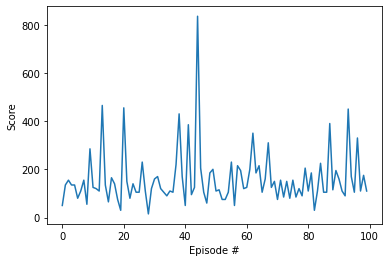

Episode 200	Average Score: 190.25


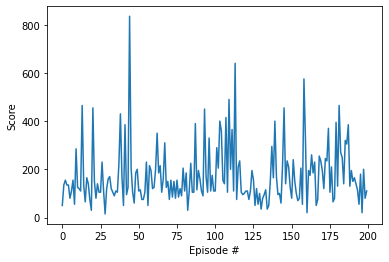

Episode 300	Average Score: 236.75


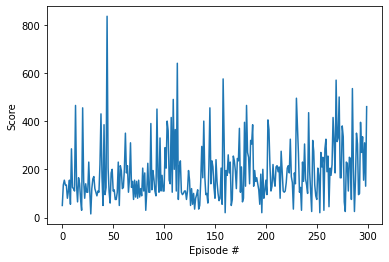

Episode 400	Average Score: 248.00


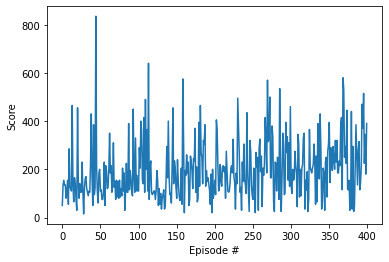

Episode 500	Average Score: 256.25


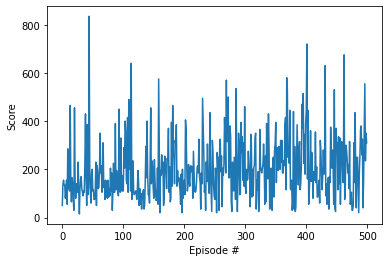

Episode 600	Average Score: 198.00


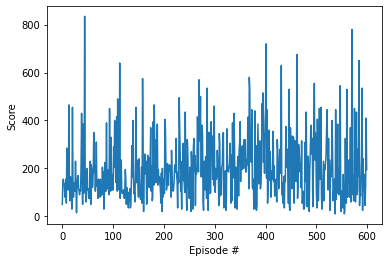

Episode 700	Average Score: 152.75


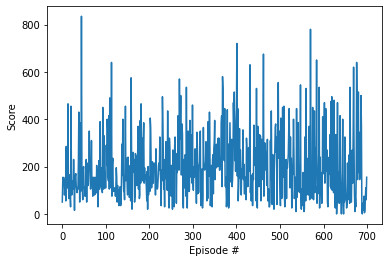

Episode 800	Average Score: 195.50


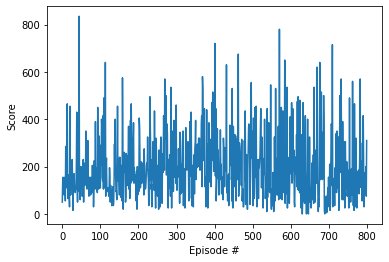

Episode 900	Average Score: 210.25


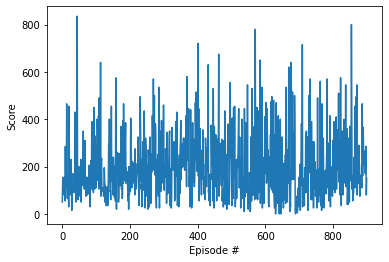

Episode 1000	Average Score: 277.25
Episode 1000	Average Score: 277.25


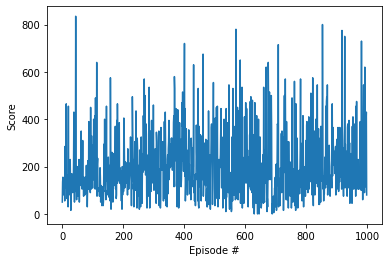

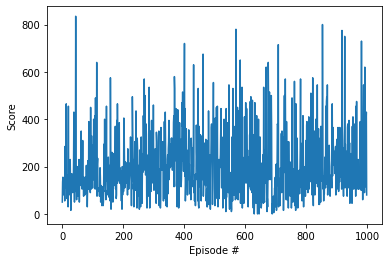

In [ ]:
scores = train(1000)

**Unfortunately**, I forgot to calculate the training time but the colab notebook calculate the executing time

### ``` Executing Time (Training): 2 h 54 min ```

## Step 10: Watch a Smart Agent!

In [ ]:
score = 0
state = stack_frames(None, env.reset(), True)
while True:
    env.render() # Comment this when use PC # it is ok for colab
    # env.render('rgb_array') # for using PC
    action = agent.act(state)
    next_state, reward, done, _ = env.step(action)
    score += reward
    state = stack_frames(state, next_state, False)
    if done:
        print("You Final score is:", score)
        break 
env.close()
show_video() # Comment this when use PC

You Final score is: 460.0
